# This is a notebook that shows the difference between all kinds of generative models mainly VAE on dataset mnist.

In [1]:
import torch
import torchvision.transforms as transforms
import argparse, os, pickle, glob, cv2
import matplotlib.pyplot as plt
import numpy as np

from utils.loss_function import select_loss_function
from utils.get_cdim import update_code_dim

from data.dataset import StanfordDog
from Solver import LinearSolver, ConvSolver

from models.simpleAE import simpleAE
from models.LinearVAE import LinearVAE
from models.ConvVAE import ConvVAE
from models.ConvVAE_little import ConvVAE_little
from models.CVAE import CVAE
from models.DVAE import DVAE
from models.GAN import Generator, Discriminator

from torchvision.datasets import MNIST
from scipy.stats import norm

### Firstly, we initialize all the settings

In [59]:
def visualize(model, train_loader, checkpoint_path):
    model.load(path=checkpoint_path)
#     torch.load(checkpoint_path, map_location='cpu')

    n = 15  # figure with 15x15 digits
    digit_size = 32
    figure = np.zeros((digit_size * n, digit_size * n, 1))
    figure1 = np.zeros((digit_size * n, digit_size * n))
    grid_x = np.linspace(-5, 5, n)
    grid_y = np.linspace(-5, 5, n)

    eg, label = next(iter(train_loader))
    print(label.shape)
    if model.model_name == 'LinearVAE' or model.model_name == 'DVAE':
        mu, sigma = model.Encoder(eg.view(eg.shape[0], 1, -1))
        print(mu.shape, sigma.shape)
        epsilon = torch.autograd.Variable(torch.randn(mu.size()), requires_grad=False).type(torch.FloatTensor)
        sigma = torch.exp(sigma / 2)
        z = (mu + sigma * epsilon).detach().numpy()[0, 0, :]
    elif model.model_name == 'ConvVAE':
        mu, sigma = model.Encoder(eg)
        epsilon = torch.autograd.Variable(torch.randn(mu.size()), requires_grad=False).type(torch.FloatTensor)
        sigma = torch.exp(sigma / 2)
        print(sigma.shape)
        z = (mu + sigma * epsilon).detach().numpy()[0, :].reshape(1, -1)
    elif model.model_name == 'CVAE':
        mu, sigma = model.Encoder(eg.view(eg.shape[0], -1), label)
        print(mu.shape, sigma.shape)
        epsilon = torch.autograd.Variable(torch.randn(mu.size()), requires_grad=False).type(torch.FloatTensor)
        sigma = torch.exp(sigma / 2)
        z = (mu + sigma * epsilon).detach().numpy()
    elif model.model_name == 'simpleAE':
        z = model.Encoder(eg.view(eg.shape[0], 1, -1)).detach().numpy()[0, 0, :]
    
    if model.model_name == 'CVAE':
#         print(z.shape)
        output = model.Decoder(torch.from_numpy(z).float(), label).reshape([32, 1, 32, 32])
    else:
#         print(z.shape)
        output = model.Decoder(torch.from_numpy(z).float()).reshape([1, 32, 32])
        
    print(output.shape)
    plt.subplot(121)
    plt.imshow(transforms.ToPILImage()(output[:, :, :].detach()))
    plt.subplot(122)
    plt.imshow(transforms.ToPILImage()(eg[0, :, :, :]).convert('RGB'))
    plt.show()
        
    if model.model_name == 'LinearVAE' or model.model_name == 'simpleAE' or model.model_name == 'DVAE' or model.model_name == 'CVAE':
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
#                 print(xi, yi)
                z_sample = np.array([xi, yi] + list(z[2:]))
#                 print(z_sample)
                x_decoded = model.Decoder(torch.from_numpy(z_sample).float()).reshape([1, 32, 32])
                digit = x_decoded.detach().numpy().reshape(32, 32)
                # plt.imshow(digit)
                # plt.show()
                figure1[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
    elif model.model_name == 'ConvVAE':
        for i, yi in enumerate(grid_x):
            for j, xi in enumerate(grid_y):
                z_sample = np.array([xi, yi] + list(z[0, 2:])).reshape(1, -1)
                x_decoded = model.Decoder(torch.from_numpy(z_sample).float()).reshape([1, 32, 32])
                digit = transforms.ToPILImage()(x_decoded[:, :, :])
                figure1[i * digit_size: (i + 1) * digit_size,
                       j * digit_size: (j + 1) * digit_size] = digit
    
    plt.figure(figsize=(10, 10))
    plt.imshow(figure1, cmap='gray_r')
    plt.show()

In [3]:
train_loader = torch.utils.data.DataLoader(dataset=MNIST('./data/mnist', train=True, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=MNIST('./data/mnist', train=False, transform=transforms.Compose([transforms.Resize(32), transforms.ToTensor()])), batch_size=32, shuffle=True)

In [4]:
max_epoch = 20
learning_rate = 1e-3
loss_function = select_loss_function('MSELoss')
z_dim = 2
batch_size = 32

In [63]:
AutoEncoder = simpleAE(n_feature=32*32*1, n_hidden=z_dim, n_output=32*32*1)
Linear_VAE = LinearVAE(z_dim=z_dim, hidden=512, num_channels=32*32*1)
Conv_VAE = ConvVAE(c_dim=update_code_dim(128, 32, 4), z_dim=128, num_channels=1)

D_VAE = DVAE(z_dim=z_dim, hidden=512, num_channels=32*32*1)
generator = Generator(z_dim=z_dim, img_shape=(1, 32, 32))
discriminator = Discriminator(img_shape=(1, 32, 32))

### Now we show how conv & linear VAE read pictures

In [6]:
optimizer = torch.optim.Adam(AutoEncoder.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8) # (beta1, beta2)
solver = LinearSolver(AutoEncoder, loss_function, optimizer, 1)
print(AutoEncoder)
solver.train_and_decode(train_loader, test_loader, test_loader, max_epoch=max_epoch)
AutoEncoder.save(dataset='mnist')

simpleAE(
  (Encoder): Encoder(
    (main): Sequential(
      (0): Linear(in_features=1024, out_features=2, bias=True)
      (1): ReLU()
    )
  )
  (Decoder): Decoder(
    (main): Sequential(
      (0): Linear(in_features=2, out_features=1024, bias=True)
      (1): ReLU()
    )
  )
)
Train:	Epoch : 0	Time : 8.56191897392273s	MSELoss : 0.086083322763443
Evaluation:	Epoch : 0	Time : 1.206110954284668s	MSELoss : 0.08067463338375092
Test:	Epoch : 0	Time : 1.2011439800262451s	MSELoss : 0.08065871894359589

Train:	Epoch : 10	Time : 11.070942163467407s	MSELoss : 0.07947705686092377
Evaluation:	Epoch : 10	Time : 1.2240300178527832s	MSELoss : 0.08067648857831955
Test:	Epoch : 10	Time : 1.2189579010009766s	MSELoss : 0.08068182319402695



'checkpoints/simpleAE_mnist_0605_11:10:55.pth'

torch.Size([1, 32, 32])


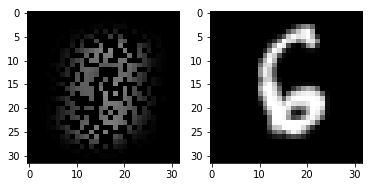

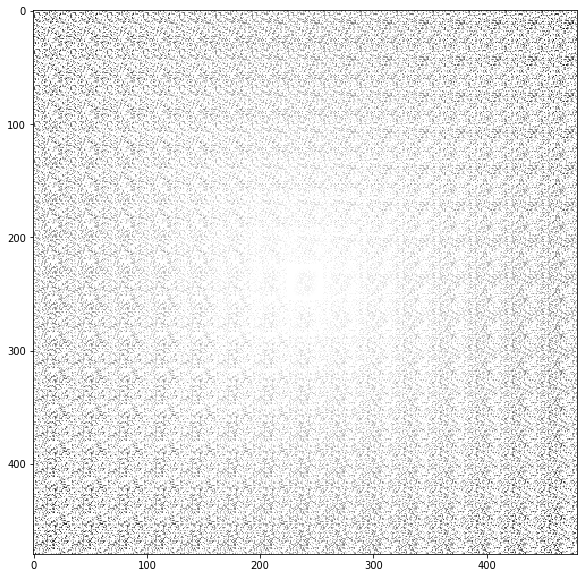

In [22]:
visualize(AutoEncoder, train_loader, 'checkpoints/simpleAE_2_mnist_0605_11:10:55.pth')

In [7]:
optimizer = torch.optim.Adam(Linear_VAE.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8) # (beta1, beta2)
solver = LinearSolver(Linear_VAE, loss_function, optimizer, 1)
print(Linear_VAE)
solver.train_and_decode(train_loader, test_loader, test_loader, max_epoch=max_epoch)
Linear_VAE.save(dataset='mnist')

LinearVAE(
  (Encoder): Encoder(
    (main): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU(inplace)
    )
    (mu_): Linear(in_features=512, out_features=2, bias=True)
    (sigma_): Linear(in_features=512, out_features=2, bias=True)
  )
  (Decoder): Decoder(
    (main): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): Sigmoid()
    )
  )
)
Train:	Epoch : 0	Time : 57.90989708900452s	MSELoss : 0.057773299515247345
Evaluation:	Epoch : 0	Time : 2.1977379322052s	MSELoss : 0.05710599198937416
Test:	Epoch : 0	Time : 2.520498037338257s	MSELoss : 0.0570969395339489

Train:	Epoch : 10	Time : 116.18433499336243s	MSELoss : 0.05650562420487404
Evaluation:	Epoch : 10	Time : 2.1978249549865723s	MSELoss : 0.056800488382577896
Test:	Epoch : 10	Time : 2.1327340602874756s	MSELoss : 0.056803565472364426



'checkpoints/simpleAE_mnist_0605_12:15:44.pth'

torch.Size([32])
torch.Size([32, 1, 2]) torch.Size([32, 1, 2])
(2,)
torch.Size([1, 32, 32])


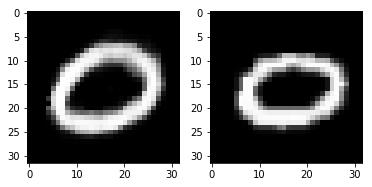

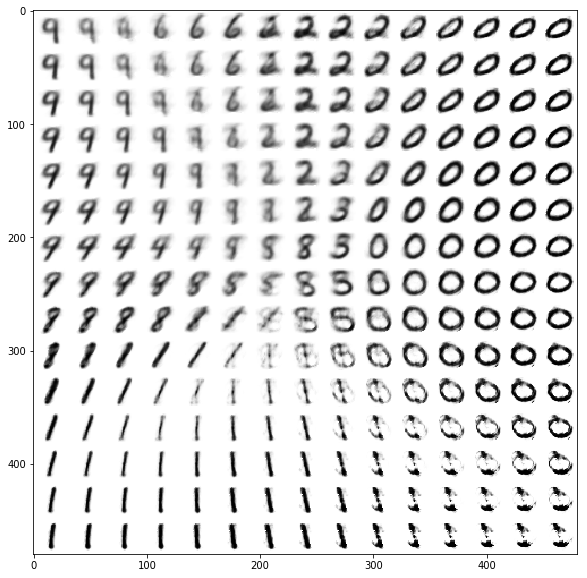

In [29]:
visualize(Linear_VAE, train_loader, 'checkpoints/LinearVAE_2_mnist_0603_20:00:28.pth')

In [7]:
optimizer = torch.optim.Adam(Conv_VAE.parameters(), lr=1e-5, betas=(0.9, 0.999), eps=1e-8) # (beta1, beta2)
solver = ConvSolver(Conv_VAE, loss_function, optimizer)
print(Conv_VAE)
solver.train_and_decode(train_loader, test_loader, test_loader, max_epoch=max_epoch)
Conv_VAE.save(dataset='mnist')

ConvVAE(
  (Encoder): Encoder(
    (main): Sequential(
      (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (1): ReLU(inplace)
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (4): ReLU(inplace)
      (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (6): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (7): ReLU(inplace)
      (8): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (9): Conv2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
      (10): ReLU(inplace)
      (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (linear_mu): Linear(in_features=512, out_features=2, bias=True)
    (sigma): Linear(in_features=512, out_f

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/torch/tensor.py:263: UserWarning: non-inplace resize is deprecated
  warnings.warn("non-inplace resize is deprecated")


KeyboardInterrupt: 

torch.Size([32])
torch.Size([32, 128])
torch.Size([1, 32, 32])


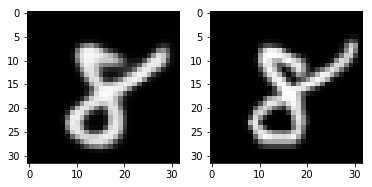

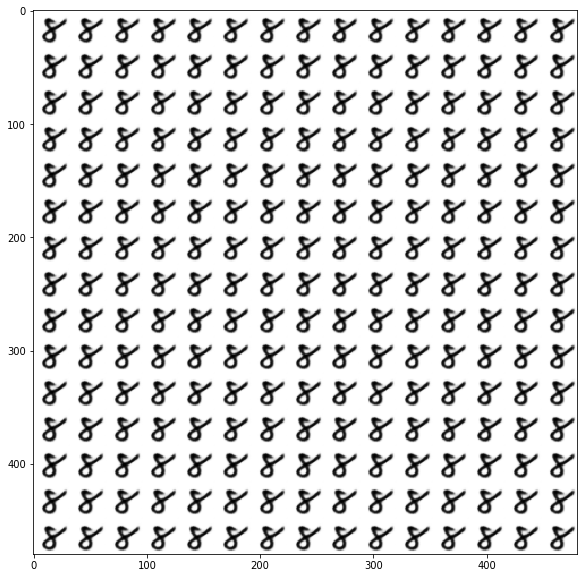

In [66]:
visualize(Conv_VAE, train_loader, './checkpoints/ConvVAE_128_mnist_0529_02:28:20.pth')

### Now we try to see the power of Conditional VAE

In [36]:
optimizer = torch.optim.Adam(C_VAE.parameters(), lr=1e-3, betas=(0.9, 0.999), eps=1e-8) # (beta1, beta2)
C_VAE = CVAE(z_dim=32, hidden=512, num_channels=32*32*1, num_labels=10)
solver = LinearSolver(C_VAE, loss_function, optimizer, 1, True)
print(C_VAE)
solver.train_and_decode(train_loader, test_loader, test_loader, max_epoch=max_epoch)
C_VAE.save(dataset='mnist')

CVAE(
  (Encoder): Encoder(
    (main): Sequential(
      (0): Linear(in_features=1034, out_features=512, bias=True)
      (1): ReLU(inplace)
    )
    (mu_): Linear(in_features=512, out_features=32, bias=True)
    (sigma_): Linear(in_features=512, out_features=32, bias=True)
  )
  (Decoder): Decoder(
    (main): Sequential(
      (0): Linear(in_features=42, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): Sigmoid()
    )
  )
)
Train:	Epoch : 0	Time : 47.40620279312134s	MSELoss : 0.22756247222423553
Evaluation:	Epoch : 0	Time : 2.7354888916015625s	MSELoss : 0.22779333591461182
Test:	Epoch : 0	Time : 2.6613759994506836s	MSELoss : 0.2277577817440033

Train:	Epoch : 10	Time : 47.83506417274475s	MSELoss : 0.22755949199199677
Evaluation:	Epoch : 10	Time : 2.8498568534851074s	MSELoss : 0.22775472700595856
Test:	Epoch : 10	Time : 2.713073968887329s	MSELoss : 0.22780904173851013



'checkpoints/CVAE_32_mnist_0606_10:23:52.pth'

torch.Size([32])
torch.Size([32, 32]) torch.Size([32, 32])
torch.Size([32, 1, 32, 32])


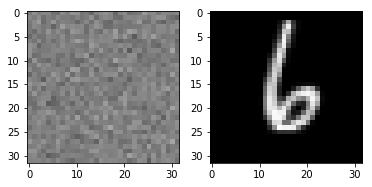

ValueError: setting an array element with a sequence.

In [37]:
visualize(C_VAE, train_loader, 'checkpoints/CVAE_32_mnist_0606_10:23:52.pth')

In [14]:
optimizer = torch.optim.Adam(D_VAE.parameters(), lr=learning_rate, betas=(0.9, 0.999), eps=1e-8) # (beta1, beta2)
solver = LinearSolver(D_VAE, loss_function, optimizer, 1)
print(D_VAE)
solver.train_and_decode(train_loader, test_loader, test_loader, max_epoch=max_epoch)
D_VAE.save(dataset='mnist')

DVAE(
  (Encoder): Encoder(
    (main): Sequential(
      (0): Linear(in_features=1024, out_features=512, bias=True)
      (1): ReLU(inplace)
    )
    (mu_): Linear(in_features=512, out_features=2, bias=True)
    (sigma_): Linear(in_features=512, out_features=2, bias=True)
  )
  (Decoder): Decoder(
    (main): Sequential(
      (0): Linear(in_features=2, out_features=512, bias=True)
      (1): ReLU(inplace)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): Sigmoid()
    )
  )
)
Train:	Epoch : 0	Time : 38.41985583305359s	MSELoss : 0.06777990609407425
Evaluation:	Epoch : 0	Time : 1.794726848602295s	MSELoss : 0.06708525121212006
Test:	Epoch : 0	Time : 1.8173928260803223s	MSELoss : 0.06705085188150406

Train:	Epoch : 10	Time : 118.71207094192505s	MSELoss : 0.06651230901479721
Evaluation:	Epoch : 10	Time : 1.810513973236084s	MSELoss : 0.06684430688619614
Test:	Epoch : 10	Time : 1.821380853652954s	MSELoss : 0.06683884561061859



'checkpoints/DVAE_2_mnist_0605_16:08:22.pth'

torch.Size([32, 1, 2]) torch.Size([32, 1, 2])
torch.Size([1, 32, 32])


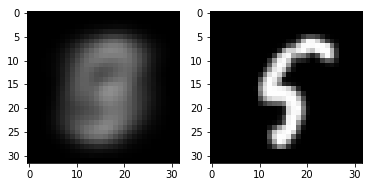

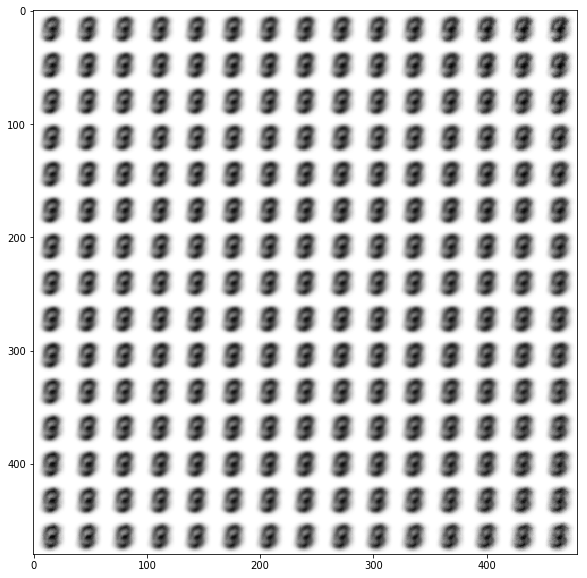

In [9]:
visualize(D_VAE, train_loader, 'checkpoints/DVAE_2_mnist_0605_16:08:22.pth')